In [82]:
# Standars libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import pickle
import itertools as it
from collections import Counter
from tld import get_fld
import pyspark
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from scipy.ndimage import gaussian_filter1d

# Utilities functions
import sys
sys.path.append('/home/fanfou/Panorama/notebooks/utils')

print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

from visualization import *
from tools import *

blue_col   = "#3498db"
red_col    = "#e74c3c"
green_col  = "#2ecc71"
orange_col = "#ff9214"

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 199)

Python version
3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Version info.
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)


In [6]:
path_to_json = "/mnt/datastore/data/medias/it/"

list_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
df_list = []

for fili in list_files:
    with open(os.path.join(path_to_json, fili), "r") as inputjson:
        df_list.append(pd.read_json(inputjson))

df = pd.concat(df_list)

In [9]:
def convert(x):
    try:
        return get_fld(x)
    except:
        return ""

df['root_domain'] = df['permalink'].map(lambda x: convert(x))

In [13]:
df_sources = pd.read_csv("/home/fanfou/Panorama/scripts/4imn_it.csv", header=None, sep=";")
df_sources[0] = df_sources[0].map(lambda x: get_fld(x))
df_sources.head()

,0,1
0,repubblica.it,repubblica
1,corriere.it,Corriere
2,gazzetta.it,Gazzetta_it
3,lastampa.it,lastampa
4,ilsole24ore.com,sole24ore


In [49]:
df_filt = df[df['root_domain'].isin(df_sources[0])]
df_filt['published'] = pd.to_datetime(df_filt['published'])

/home/fanfou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [64]:
df_filt_by_date = df_filt.resample('D', on='published').count()

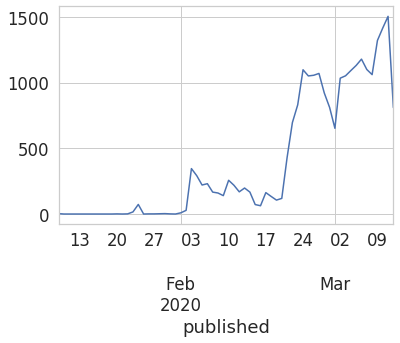

In [66]:
df_filt_by_date['permalink'].plot()

In [68]:
df_filt_by_date['permalink'].to_csv("/mnt/datastore/data/medias/media_italy.csv", header=None)

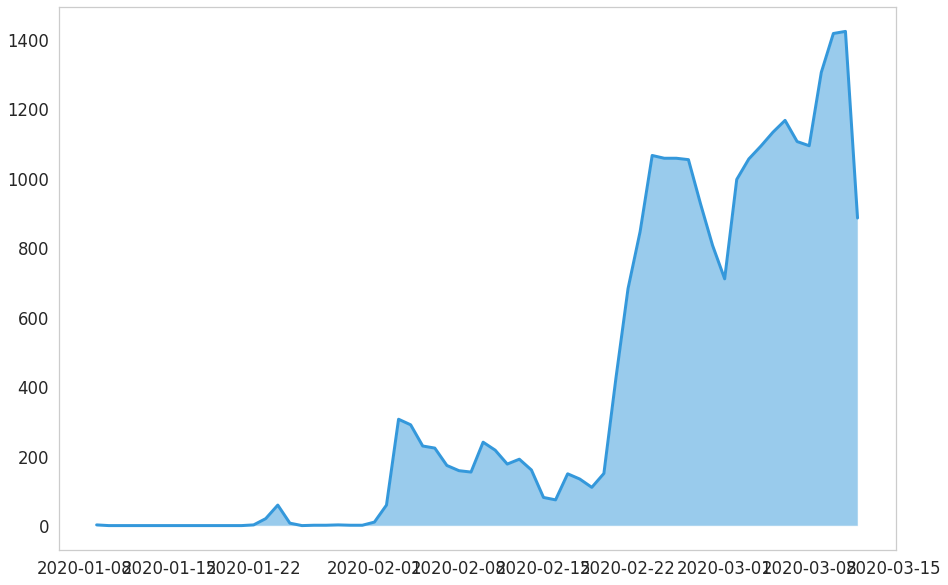

In [90]:
from scipy.ndimage.filters import gaussian_filter1d

plt.figure(figsize=(15,10))
signal = gaussian_filter1d(df_filt_by_date['permalink'], sigma=.5)
plt.plot(df_filt_by_date.index.values,signal,  color=blue_col, linewidth=3)
plt.fill_between(df_filt_by_date.index.values,signal, facecolor=blue_col, alpha=0.5)
plt.grid(False)